# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow
tensorflow.__version__

'2.0.0'

#### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#### Change current working directory to project folder

In [ ]:
import os
os.chdir("drive/My Drive/Colab Notebooks")

### Extract the zip file
- Extract Aligned Face Dataset from Pinterest.zip

In [ ]:
from zipfile import ZipFile

In [ ]:
filename = 'Aligned Face Dataset from Pinterest.zip'
with ZipFile(filename, 'r') as zip:
  zip.extractall()

### Function to load images
- Define a function to load the images from the extracted folder and map each image with person id 


In [ ]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

### Define function to load image
- Define a function to load image from the metadata

In [ ]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

#### Load a sample image
- Load one image using the function "load_image"

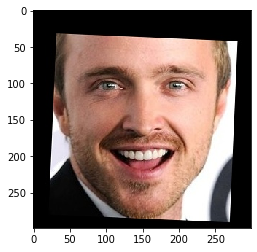

In [9]:
one_image = load_image(metadata[11].image_path())

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

plt.imshow(one_image)

### VGG Face model
- Here we are giving you the predefined model for VGG face

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
model = vgg_face()

In [ ]:
import h5py
model.load_weights('vgg_face_weights.h5')

### Get vgg_face_descriptor

In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

In [14]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


### Generate embeddings for all images
- Write code to iterate through metadata and create embeddings for each image using `vgg_face_descriptor.predict()` and store in a list with name `embeddings`

- If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [15]:
imageList = []
image_paths = []
embedding_vectorlist = []
LabelList = []

for i in range(0,metadata.shape[0]):
    if i % 100 == 0:
        print(i)
    img_path = metadata[i].image_path()
    image_paths.append(img_path)
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    imageList.append(img)
    splits = img_path.split('\\') 
    LabelList.append(splits[-1])
    try:
        embedding_vectorlist.append(vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0])
    except:
        embedding_vectorlist.append(np.zeros(shape=(2622)))

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700


In [ ]:
LabelList = []
for i in range(0,metadata.shape[0]):
    img_path = metadata[i].image_path()
    splits = img_path.split('\\') 
    LabelList.append(splits[-1])

### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

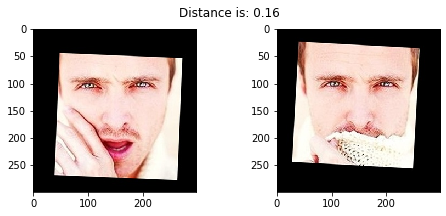

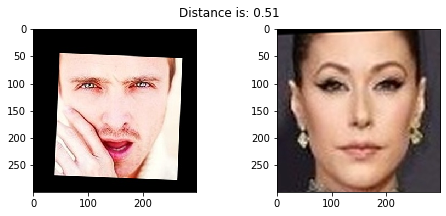

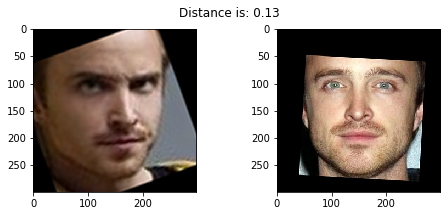

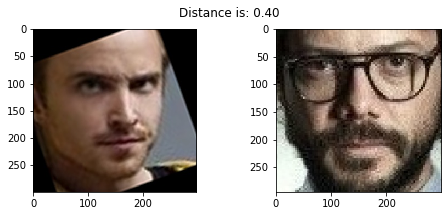

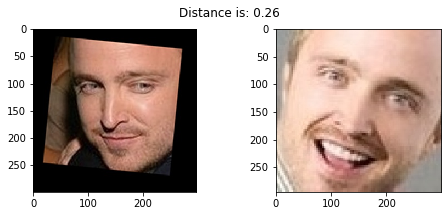

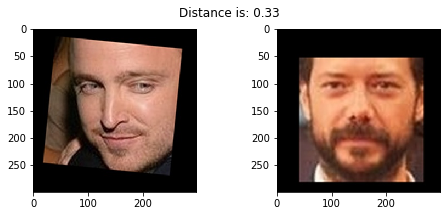

In [20]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance is: {distance(embedding_vectorlist[idx1], embedding_vectorlist[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

show_pair(30, 31)
show_pair(30, 100)

show_pair(70,72)
show_pair(70, 115)

### Create train and test sets
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [21]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

import pandas as pd
basedf = pd.DataFrame(embedding_vectorlist)

print('Shape of x-train Matrix')
X_train = basedf[train_idx]
print(X_train.shape)

print('Shape of x-test Matrix')
X_test = basedf[test_idx]
print(X_test.shape)

LabelDF = pd.DataFrame(LabelList)

print('Shape of y-train vector')
y_train = LabelDF[train_idx]
print(y_train.shape)

print('Shape of y-test vector')
y_test = LabelDF[test_idx]
print(y_test.shape)


Shape of x-train Matrix
(9573, 2622)
Shape of x-test Matrix
(1197, 2622)
Shape of y-train vector
(9573, 1)
Shape of y-test vector
(1197, 1)


### Encode the Labels
- Encode the targets
- Use LabelEncoder

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(LabelDF)

le.classes_[0:18]

TransformedLabels = le.transform(LabelDF)

TransformedLabeslsDF = pd.DataFrame(TransformedLabels)
y_train = TransformedLabeslsDF[train_idx]
y_test = TransformedLabeslsDF[test_idx]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Standardize the feature values
- Scale the features using StandardScaler

In [23]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(basedf)
print(scaler.mean_)
basdf_new_scaled = scaler.transform(basedf)

[ 0.01083115 -0.0003015   0.00288542 ... -0.01445758  0.00593633
  0.01350416]


### Reduce dimensions using PCA
- Reduce feature dimensions using Principal Component Analysis

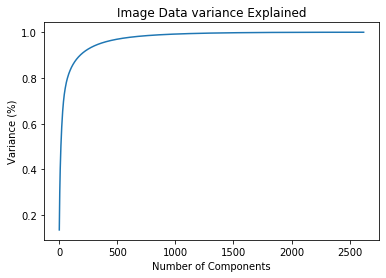

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA()
basdf_new_PCA = pca.fit(basdf_new_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Image Data variance Explained')
plt.show()

### Build a Classifier
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
from sklearn.svm import SVC



svclassifier = SVC(kernel='poly' , degree=4)
svclassifier.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
y_pred = svclassifier.predict(X_test)
print(y_pred)

### Test results

---


- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

In [ ]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 1040

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_pred
example_identity = le.inverse_transform(example_prediction)[example_idx]

plt.imshow(example_image)
plt.title(f'Person has been identfied. They are: {example_identity}');